# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from datetime import datetime
from dateutil.parser import parse
from scipy.stats.mstats import winsorize

# building a simple linear regression model using statsmodels
from statsmodels.formula.api import ols

# Step 1: Read in Data

In [4]:
df = pd.read_csv('kc_house_data_train.csv')

# Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

Initial notes on feature
- day of the sell is most likely useless but could vary on time of year
- number of bath and bed could be combined for total
    - could look at houses over some threshold of bed and baths
- could look at percentage of home vs lot size (this could be area for yard)
- could do over or under certain amount of floors
- waterfront = BIG MONEY
- condition is going to be a huge factor
- grade also big indicator
- coudl add basement and above to get total square feet
- could create new figure of years since it was built (renovation could reset this)
- certain zipcodes are going to be more expensive than others
- dont know how lat and long could be used
- the houses nearby can give a sense of how big the houses are nearby

In [5]:
# removing unnecessary column, provides no info
df = df.drop(['Unnamed: 0','id'], axis=1)
pd.options.display.max_columns = None

In [6]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [7]:
df.tail()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17285,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400
17286,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013
17287,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403
17288,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028
17289,20150116T000000,348000.0,3,1.50,1330,6768,1.0,0,0,4,7,1330,0,1952,0,98155,47.7366,-122.319,1320,6910


In [8]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


In [9]:
df.corr()['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.703540
grade            0.666215
sqft_above       0.607760
sqft_living15    0.585567
bathrooms        0.524335
view             0.395485
sqft_basement    0.323312
bedrooms         0.305106
lat              0.302394
waterfront       0.275779
floors           0.256985
yr_renovated     0.117770
sqft_lot         0.086803
sqft_lot15       0.081423
yr_built         0.056450
condition        0.036099
long             0.019327
zipcode         -0.048958
Name: price, dtype: float64

Text(0.5, 1.0, 'View')

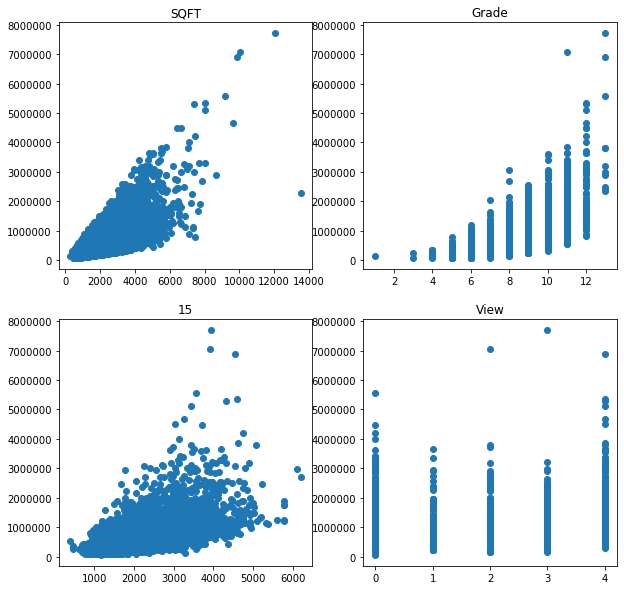

In [10]:
x_sqft = df.sqft_living
x_grade = df.grade
x_sqft15 = df.sqft_living15
x_view = df.view
y_price_test = df.price

fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(x_sqft,y_price_test)
ax[0,0].set_title('SQFT')
ax[0,1].scatter(x_grade,y_price_test)
ax[0,1].set_title('Grade')
ax[1,0].scatter(x_sqft15,y_price_test)
ax[1,0].set_title('15')
ax[1,1].scatter(x_view,y_price_test)
ax[1,1].set_title('View')

In [11]:
#sns.pairplot(df)

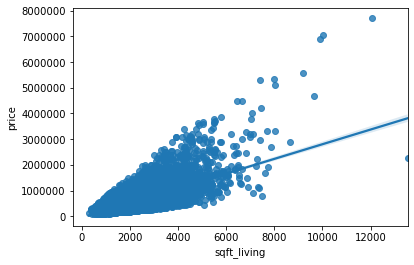

In [12]:
sns.regplot('sqft_living','price',data=df)

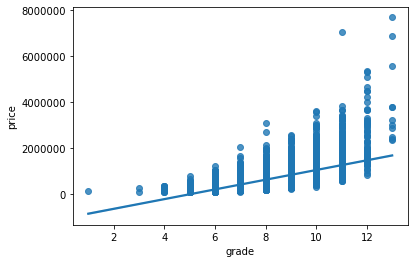

In [13]:
sns.regplot('grade','price',data=df)

In [14]:
slr_model = ols(formula='price~sqft_living+grade+sqft_above', data=df).fit()
slr_model.t_test

<bound method LikelihoodModelResults.t_test of <statsmodels.regression.linear_model.OLSResults object at 0x7faf3b9f0b70>>

# Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

In [15]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


In [16]:
"""
OUTLIERS
- bed and bath seem to have some extreme values
- sqft has a large outlier
- sqft 15 has outlier but assuming fancy neighbor hood
"""

'\nOUTLIERS\n- bed and bath seem to have some extreme values\n- sqft has a large outlier\n- sqft 15 has outlier but assuming fancy neighbor hood\n'

In [17]:
a = np.array([10, 4, 9, 8, 5, 3, 7, 2, 1, 6])
winsorize(a, limits=[0.1, 0.1],inclusive=(False,True))

masked_array(data=[9, 4, 9, 8, 5, 3, 7, 2, 2, 6],
             mask=False,
       fill_value=999999)

# Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

NEW FEATURES
- has_basement : if it has a basement or not (is the basement sqft > 0)
- DONE **** year_since_build : years since it was built
- total_sqft : basement and house sqft combined **IS SQFT LIVING**
- multi_level : if it has more than 1 floor
- avg_sqft_neighbors : the avg square feet of neighbors homs
- avg_lot_neighbors : the avg lot size of neighbors
- DONE is_renovated : has the house been renovated

### 4.1) Identify a categorical variable in the data set and create dummy columns.

satisfied with is multi floor

### 4.2) There is a column that gives the date for when the house was sold, how could this be useful in your model? How might you transform the current column to a more useful feature?

# ----------\*Changing date to datetime\*-----------

In [18]:
# converting date to a real datetime
df.date = pd.to_datetime(df['date'])

In [19]:
# could look at the prices of homes throught the year
# could be more money at some points and less at others
df['month_sold'] = df.date.dt.month

In [20]:
selling_month = df.groupby(['month_sold']).mean()['price']

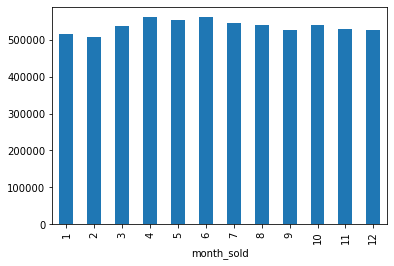

In [21]:
selling_month.plot(kind='bar')

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

# --------\*MAKING YEAR SINCE BUILD\*---------

In [22]:
# this could be used as day since build / renovation
# this could be seen as 'how new' the house is
conditions = [
    df['yr_renovated'] > df['yr_built'],
]
choices = [
    2020-df['yr_renovated']
]
df['yr_since_build'] = np.select(conditions,choices,default=(2020-df['yr_built']))

# -------- \*MAKING IS MULTI FLOOR\* ---------

In [23]:
df.floors.value_counts()

1.0    8606
2.0    6538
1.5    1524
3.0     475
2.5     140
3.5       7
Name: floors, dtype: int64

In [24]:
df['is_multi_floor'] = df['floors'].apply(lambda x: 1 if x > 1 else 0)


In [25]:
df.is_multi_floor.value_counts()

1    8684
0    8606
Name: is_multi_floor, dtype: int64

In [26]:
df.groupby('is_multi_floor').mean()['price']

is_multi_floor
0    443405.040785
1    637199.794450
Name: price, dtype: float64

In [27]:
df.groupby('is_multi_floor').median()['price']

is_multi_floor
0    390000.0
1    540000.0
Name: price, dtype: float64

# ---------\*MAKING Has Basement\* -----------

In [28]:
df.sqft_basement.describe()

count    17290.000000
mean       292.158589
std        443.151874
min          0.000000
25%          0.000000
50%          0.000000
75%        560.000000
max       4820.000000
Name: sqft_basement, dtype: float64

In [29]:
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


In [30]:
df['has_basement'].value_counts()

0    10484
1     6806
Name: has_basement, dtype: int64

In [31]:
df.groupby('has_basement').mean()['price']

has_basement
0    487510.298932
1    622734.178960
Name: price, dtype: float64

In [32]:
df.groupby('has_basement').median()['price']

has_basement
0    411802.5
1    514850.0
Name: price, dtype: float64

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [33]:
# looking at the view feature we can see an amount of polynomial up-down-up that could be better described as a poly
# year since build also has this because it could be new and very old houses sell for more then just old houses

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 24 columns):
date              17290 non-null datetime64[ns]
price             17290 non-null float64
bedrooms          17290 non-null int64
bathrooms         17290 non-null float64
sqft_living       17290 non-null int64
sqft_lot          17290 non-null int64
floors            17290 non-null float64
waterfront        17290 non-null int64
view              17290 non-null int64
condition         17290 non-null int64
grade             17290 non-null int64
sqft_above        17290 non-null int64
sqft_basement     17290 non-null int64
yr_built          17290 non-null int64
yr_renovated      17290 non-null int64
zipcode           17290 non-null int64
lat               17290 non-null float64
long              17290 non-null float64
sqft_living15     17290 non-null int64
sqft_lot15        17290 non-null int64
month_sold        17290 non-null int64
yr_since_build    17290 non-null int64
is_multi_floor

In [35]:
tdf = df[['price','view']]
x = tdf.drop(columns='price',axis=1)
y = tdf['price']
print(len(x),len(y))

17290 17290


Text(0, 0.5, 'price')

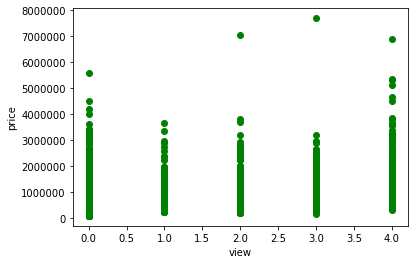

In [36]:
plt.scatter(x, y, color='green')
plt.xlabel('view')
plt.ylabel('price')

In [37]:
from sklearn.linear_model import LinearRegression
#x.reshape(-1,1)
reg = LinearRegression().fit(x, y)

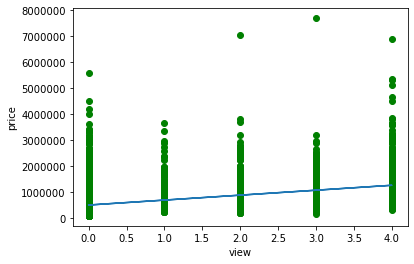

In [38]:
plt.scatter(x, y, color='green')
plt.plot(x, reg.predict(x))
plt.xlabel('view')
plt.ylabel('price');

In [39]:
x['view_square'] = x.view**2

In [40]:
reg = LinearRegression().fit(x, y)

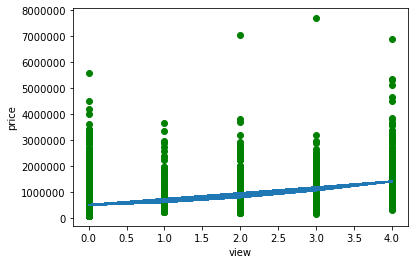

In [41]:
plt.scatter(x.view, y, color='green')
plt.plot(x['view'], reg.predict(x))
plt.xlabel('view')
plt.ylabel('price');

In [42]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,yr_since_build,is_multi_floor,has_basement
0,2014-10-06,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,10,34,1,0
1,2014-08-21,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,8,43,0,1
2,2014-08-15,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,8,23,1,0
3,2015-03-31,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,3,30,1,0
4,2014-07-14,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,7,16,1,0


### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [43]:
# I think a good pair here would be waterfront and x
# another pairing could be # of rooms and sqft

## Statistical Tests

#### Number 1
* Ho - There is no difference in price between waterfront and not
* Ha - There is a difference in price

#### Number 2
* Ho - A basement will not increase the price of a home
* Ha - A basement will increase a price of a home

#### Number 3
* Ho - a house is the same sqft as its 15 neighbors
* Ha - a house is not the same as the 15 neighbors

#### Number 4
* Ho - a house price doesnt matter on the month sold
* Ha - a house price does depend on the month sold

In [44]:
from scipy.stats import t
from scipy import stats

In [45]:
# Number 1
# going to use a two sample t-test
water = df[df['waterfront'] > 0.5]
land = df[(df.waterfront < 0.5)]
dfree = len(water) + len(land) - 1
a = 0.025
value= t.ppf(a, dfree)
print('the critical value is '+str(value))
p = t.cdf(value,dfree)
print('the p value is '+str(p))
stats.ttest_ind(water['price'], land['price'])

the critical value is -1.9601012067329433
the p value is 0.024999999999999977


Ttest_indResult(statistic=37.72330429549608, pvalue=2.465038317654299e-299)

**We can reject the null hypothesis so we can see that waterfront definitly does change the price**

In [46]:
basement = df[df['has_basement'] == 1]
nobase = df[df['has_basement'] == 0]
dfree = len(basement) + len(nobase) - 2
a = 0.05
value= t.ppf(a, dfree)
print('the critical value is '+str(value))
p = t.cdf(value,dfree)
print('the p value is '+str(p))
stats.ttest_ind(basement['price'], nobase['price'])


the critical value is -1.6449417719827377
the p value is 0.04999999999999998


Ttest_indResult(statistic=23.64189256331611, pvalue=1.2107663322174255e-121)

**We can reject the null hypothesis so we can see that a basement does increase the price**

# Step 5: Train-Test Split

If you plan on doing any scaling of your data, make sure it is done at the appropriate time. 

### 5.1) Perform a train-test split of the data.

In [47]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=10)
print(len(train_set), "train +", len(test_set), "test")



13832 train + 3458 test


In [48]:
train_set.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,yr_since_build,is_multi_floor,has_basement
5441,2015-03-20,234975.0,3,1.75,1650,8073,1.0,0,0,3,7,1100,550,1980,0,98092,47.3187,-122.182,1280,8073,3,40,0,1
14396,2015-04-13,456000.0,3,2.50,1820,2935,2.0,0,0,3,8,1820,0,1999,0,98074,47.6018,-122.021,1820,2936,4,21,1,0
12517,2014-06-06,270000.0,4,2.25,1900,8600,1.0,0,0,4,8,1900,0,1975,0,98023,47.3102,-122.381,2120,8000,6,45,0,0
12895,2014-10-02,300000.0,4,1.00,1730,177657,1.5,0,0,3,5,1730,0,1948,0,98065,47.5163,-121.829,1400,45175,10,72,1,0
5137,2014-10-03,857500.0,3,1.50,2040,3960,2.0,0,2,5,8,2040,0,1928,0,98103,47.6658,-122.355,1540,3400,10,92,1,0


In [49]:
x_train = train_set.drop(columns=['price'])
y_train = train_set['price']

### Baseline Regression

In [50]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor()
dummy.fit(x_train,y_train)
dummy.score(x_train,y_train)

0.0

In [51]:
y_pred = dummy.predict(x_train)

In [52]:
from sklearn.metrics import mean_squared_error
dummy_rmse = mean_squared_error(y_train, y_pred)
dummy_rmse

139778503578.24057

### Liner Regression

In [53]:
x_train = x_train.drop(columns=['date'])

In [54]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
print(lr.coef_)
print()
print(lr.intercept_)

[-3.86471130e+04  4.65181039e+04  1.14419974e+02  1.83451234e-01
  5.46026116e+04  6.21562873e+05  4.80806385e+04  2.80513089e+04
  9.65570977e+04  7.34604138e+01  4.09595604e+01 -2.81271424e+03
  2.02385601e+01 -5.38024121e+02  5.81606128e+05 -2.11787056e+05
  2.40410709e+01 -3.98187220e-01 -2.71113349e+03  1.13564849e+02
 -5.63962086e+04 -4.07212478e+03]

4020258.9391151066


In [56]:
y_pred = lr.predict(x_train)

In [57]:
lr.score(x_train, y_train)

0.7039488385281437

In [85]:
lr_rsme = mean_squared_error(y_train, y_pred)
# square root of the sme that i getxt
np.sqrt(lr_rsme)

203424.65025934338

### 5.2) Fit your scaler to training the data.

In [ ]:
#your code here 

### 5.3) Transform the testing set with the scaler.

In [ ]:
#your code here 

### 5.4) Fit the model to the training data.

In [ ]:
#your code here 

### 5.5) Use the model to predict on the training set and the test set.

In [ ]:
#your code here 

### 5.6) Evaluate the training and test predictions using RMSE.

In [ ]:
#your code here 

### 5.7) Determine if your model is overfit.

In [ ]:
#your code here 

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.

### 6.1) Utilize a filter method to identify some features to remove from the model.  

 https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection
 
 - can use different tests to determine which features are the best
 - get rid of the bottom ones that dont me a threshold
Pearson’s Correlation: It is used as a measure for quantifying linear dependence between two continuous variables X and Y. Its value varies from -1 to +1. Pearson’s correlation is given as:
Pearsons Correlation - scipy.stats.pearsonr - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

LDA -  Linear discriminant analysis is used to find a linear combination of features that characterizes or separates two or more classes (or levels) of a categorical variable.
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

Anova - ANOVA stands for Analysis of variance. It is similar to LDA except for the fact that it is operated using one or more categorical independent features and one continuous dependent feature. It provides a statistical test of whether the means of several groups are equal or not. - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html


Chi-Square - It is a is a statistical test applied to the groups of categorical features to evaluate the likelihood of correlation or association between them using their frequency distribution.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html

Mutual Information Regresson - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#sklearn.feature_selection.mutual_info_regression

## Data Manip for evaluation

In [62]:
# Getting rid of columns I dont wanna consider
fs_df = df.drop(columns=['date','zipcode','lat','long'])

## Pearsons

In [63]:
pearson_scores = []
features = list(fs_df.columns)
y = fs_df['price']
for feature in features:
    x = fs_df[feature]
    score = stats.pearsonr(x,y)
    pearson_scores.append((feature,score))

In [64]:
pearson_scores

[('price', (1.0, 0.0)),
 ('bedrooms', (0.30510571026815514, 0.0)),
 ('bathrooms', (0.5243346054984268, 0.0)),
 ('sqft_living', (0.7035403039789669, 0.0)),
 ('sqft_lot', (0.0868031093524548, 2.8073725559685796e-30)),
 ('floors', (0.25698507185137404, 7.67514444155681e-259)),
 ('waterfront', (0.27577867080466206, 2.465038317624179e-299)),
 ('view', (0.3954851030218899, 0.0)),
 ('condition', (0.03609884124957833, 2.0554674592679736e-06)),
 ('grade', (0.6662149551378924, 0.0)),
 ('sqft_above', (0.6077596929372431, 0.0)),
 ('sqft_basement', (0.3233117680868857, 0.0)),
 ('yr_built', (0.05645007489461683, 1.1017832792233933e-13)),
 ('yr_renovated', (0.11776994288661466, 1.8973597280705488e-54)),
 ('sqft_living15', (0.5855670702254931, 0.0)),
 ('sqft_lot15', (0.08142253547125156, 7.904286247919057e-27)),
 ('month_sold', (-0.00435000399207986, 0.5673560787416599)),
 ('yr_since_build', (-0.10481172535759761, 1.9597944081099783e-43)),
 ('is_multi_floor', (0.2595613899856133, 3.3717279344584765e-2

In [70]:
sorted(pearson_scores,key = lambda x: np.abs(x[1][0]),reverse=True)

[('price', (1.0, 0.0)),
 ('sqft_living', (0.7035403039789669, 0.0)),
 ('grade', (0.6662149551378924, 0.0)),
 ('sqft_above', (0.6077596929372431, 0.0)),
 ('sqft_living15', (0.5855670702254931, 0.0)),
 ('bathrooms', (0.5243346054984268, 0.0)),
 ('view', (0.3954851030218899, 0.0)),
 ('sqft_basement', (0.3233117680868857, 0.0)),
 ('bedrooms', (0.30510571026815514, 0.0)),
 ('waterfront', (0.27577867080466206, 2.465038317624179e-299)),
 ('is_multi_floor', (0.2595613899856133, 3.3717279344584765e-264)),
 ('floors', (0.25698507185137404, 7.67514444155681e-259)),
 ('has_basement', (0.17697029253082647, 1.2107663322037226e-121)),
 ('yr_renovated', (0.11776994288661466, 1.8973597280705488e-54)),
 ('yr_since_build', (-0.10481172535759761, 1.9597944081099783e-43)),
 ('sqft_lot', (0.0868031093524548, 2.8073725559685796e-30)),
 ('sqft_lot15', (0.08142253547125156, 7.904286247919057e-27)),
 ('yr_built', (0.05645007489461683, 1.1017832792233933e-13)),
 ('condition', (0.03609884124957833, 2.055467459267

Going to remove all features will coeficients less than 0.3

Remaining Features:
- sqft_living
- grade
- sqft_above
- sqft_living15
- bathrooms
- view
- sqft_basement
- bedrooms

In [87]:
x_train = train_set[['sqft_living','grade','sqft_above','sqft_living15','bathrooms','view','sqft_basement','bedrooms']]
y_train = train_set['price']


In [88]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_train)

lr.score(x_train, y_train)

lr_rsme = mean_squared_error(y_train, y_pred)
# square root of the sme that i getxt
np.sqrt(lr_rsme)

241453.08150900877

In [90]:
slr_model = ols(formula='price~sqft_living+grade+sqft_above+sqft_living15+bathrooms+view+sqft_basement+bedrooms', data=train_set).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     2760.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:30:31   Log-Likelihood:            -1.9107e+05
No. Observations:               13832   AIC:                         3.821e+05
Df Residuals:                   13824   BIC:                         3.822e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -4.921e+05   1.86e+04    -26.389      0.000   -5.29e+05   -4.56e+05
sqft_living     142.0368      3.233     43.929      0.000     135.699     148.375
grade          9.951e+04   3064.336     32.473      0.000    9.35e+04    1.06e+05
sqft_above       48.9800      3.024     16.199      0.000      43.053      54.907
sqft_living15     5.2794      4.933      1.070      0.285      -4.390      14.949
bathrooms     -2.353e+04   4246.406     -5.542      0.000   -3.19e+04   -1.52e+04
view           8.563e+04   2862.643     29.913      0.000       8e+04    9.12e+04
sqft_basement    93.0568      3.423     27.186      0.000      86.347      99.766
bedrooms      -3.594e+04   2907.019    -12.362      0.000   -4.16e+04   -3.02e+04
==============================================================================
Omnibus:                    10882.576   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           755700.318
Skew:                           3.250   Prob(JB):                         0.00
Kurtosis:                      38.623   Cond. No.                     1.18e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.33e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Anova

In [72]:
import sklearn
from sklearn.feature_selection import f_classif
anova_scores = []
features = list(fs_df.columns)
y = fs_df['price']
for feature in features:
    x = fs_df[feature].to_frame()
    score = sklearn.feature_selection.f_classif(x,y)
    anova_scores.append((feature,score))

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [73]:
anova_scores

[('price', (array([inf]), array([0.]))),
 ('bedrooms', (array([1.61784934]), array([9.86921073e-80]))),
 ('bathrooms', (array([3.38617447]), array([0.]))),
 ('sqft_living', (array([7.00373116]), array([0.]))),
 ('sqft_lot', (array([0.83466265]), array([1.]))),
 ('floors', (array([1.55087179]), array([3.1977288e-66]))),
 ('waterfront', (array([2.96976763]), array([0.]))),
 ('view', (array([2.39131804]), array([2.77115726e-273]))),
 ('condition', (array([1.06647895]), array([0.0074789]))),
 ('grade', (array([6.57947407]), array([0.]))),
 ('sqft_above', (array([4.80480949]), array([0.]))),
 ('sqft_basement', (array([1.82811314]), array([1.14994227e-126]))),
 ('yr_built', (array([1.2562368]), array([1.09218355e-18]))),
 ('yr_renovated', (array([1.25508777]), array([1.49906835e-18]))),
 ('sqft_living15', (array([4.90852246]), array([0.]))),
 ('sqft_lot15', (array([0.73489603]), array([1.]))),
 ('month_sold', (array([0.97271654]), array([0.8482486]))),
 ('yr_since_build', (array([1.27484757]

In [80]:
sorted(anova_scores, key = lambda x: x[1][1], reverse = False)

[('price', (array([inf]), array([0.]))),
 ('bathrooms', (array([3.38617447]), array([0.]))),
 ('sqft_living', (array([7.00373116]), array([0.]))),
 ('waterfront', (array([2.96976763]), array([0.]))),
 ('grade', (array([6.57947407]), array([0.]))),
 ('sqft_above', (array([4.80480949]), array([0.]))),
 ('sqft_living15', (array([4.90852246]), array([0.]))),
 ('view', (array([2.39131804]), array([2.77115726e-273]))),
 ('sqft_basement', (array([1.82811314]), array([1.14994227e-126]))),
 ('bedrooms', (array([1.61784934]), array([9.86921073e-80]))),
 ('is_multi_floor', (array([1.56866677]), array([9.87494718e-70]))),
 ('floors', (array([1.55087179]), array([3.1977288e-66]))),
 ('yr_since_build', (array([1.27484757]), array([5.61437363e-21]))),
 ('yr_built', (array([1.2562368]), array([1.09218355e-18]))),
 ('yr_renovated', (array([1.25508777]), array([1.49906835e-18]))),
 ('has_basement', (array([1.24724407]), array([1.26649268e-17]))),
 ('condition', (array([1.06647895]), array([0.0074789])))

keeping features that are significant
bathrooms + sqft_living + waterfront + grade + sqft_above + sqft_living15 + 

## Chi squared

In [74]:
from sklearn.feature_selection import chi2
chi2_scores = []
features = list(fs_df.columns)
y = fs_df['price']
for feature in features:
    x = fs_df[feature].to_frame()
    score = sklearn.feature_selection.chi2(x,y)
    chi2_scores.append((feature,score))

In [75]:
chi2_scores

[('price', (array([4.4559661e+09]), array([0.]))),
 ('bedrooms', (array([1327.84326322]), array([1.]))),
 ('bathrooms', (array([2260.47181738]), array([1.]))),
 ('sqft_living', (array([4518604.4136103]), array([0.]))),
 ('sqft_lot', (array([3.5832359e+08]), array([0.]))),
 ('floors', (array([959.72341548]), array([1.]))),
 ('waterfront', (array([7421.66872654]), array([9.26498195e-278]))),
 ('view', (array([16574.70507517]), array([0.]))),
 ('condition', (array([462.62431459]), array([1.]))),
 ('grade', (array([1958.13635913]), array([1.]))),
 ('sqft_above', (array([3670368.04345156]), array([0.]))),
 ('sqft_basement', (array([3713088.45044686]), array([0.]))),
 ('yr_built', (array([1842.61053971]), array([1.]))),
 ('yr_renovated', (array([8059493.82407293]), array([0.]))),
 ('sqft_living15', (array([2274321.52488382]), array([0.]))),
 ('sqft_lot15', (array([1.58079648e+08]), array([0.]))),
 ('month_sold', (array([5110.09384103]), array([1.01893596e-61]))),
 ('yr_since_build', (array([

In [95]:
chi2_scores = sorted(chi2_scores, key = lambda x: x[1][1], reverse = False)
chi2_scores

[('price', (array([4.4559661e+09]), array([0.]))),
 ('sqft_living', (array([4518604.4136103]), array([0.]))),
 ('sqft_lot', (array([3.5832359e+08]), array([0.]))),
 ('view', (array([16574.70507517]), array([0.]))),
 ('sqft_above', (array([3670368.04345156]), array([0.]))),
 ('sqft_basement', (array([3713088.45044686]), array([0.]))),
 ('yr_renovated', (array([8059493.82407293]), array([0.]))),
 ('sqft_living15', (array([2274321.52488382]), array([0.]))),
 ('sqft_lot15', (array([1.58079648e+08]), array([0.]))),
 ('yr_since_build', (array([75544.00392371]), array([0.]))),
 ('waterfront', (array([7421.66872654]), array([9.26498195e-278]))),
 ('month_sold', (array([5110.09384103]), array([1.01893596e-61]))),
 ('bedrooms', (array([1327.84326322]), array([1.]))),
 ('bathrooms', (array([2260.47181738]), array([1.]))),
 ('floors', (array([959.72341548]), array([1.]))),
 ('condition', (array([462.62431459]), array([1.]))),
 ('grade', (array([1958.13635913]), array([1.]))),
 ('yr_built', (array(

In [104]:
string = ''
for item in chi2_scores[1:12]:
    string = string+"','"+item[0]

string

"','sqft_living','sqft_lot','view','sqft_above','sqft_basement','yr_renovated','sqft_living15','sqft_lot15','yr_since_build','waterfront','month_sold"

In [105]:
x_train = train_set[['sqft_living','sqft_lot','view','sqft_above','sqft_basement','yr_renovated','sqft_living15','sqft_lot15','yr_since_build','waterfront','month_sold']]
y_train = train_set['price']

In [106]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_train)

lr.score(x_train, y_train)

lr_rsme = mean_squared_error(y_train, y_pred)
# square root of the sme that i getxt
np.sqrt(lr_rsme)

238872.57446155042

In [103]:
slr_model = ols(formula='price~sqft_living+view+sqft_above+sqft_basement+yr_renovated+sqft_living15+sqft_lot15+yr_since_build+waterfront+month_sold', data=train_set).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     2226.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:38:55   Log-Likelihood:            -1.9092e+05
No. Observations:               13832   AIC:                         3.819e+05
Df Residuals:                   13822   BIC:                         3.819e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -2.449e+05   9817.921    -24.940      0.000   -2.64e+05   -2.26e+05
sqft_living      158.2229      2.368     66.813      0.000     153.581     162.865
view             5.81e+04   3064.707     18.958      0.000    5.21e+04    6.41e+04
sqft_above       101.9299      2.726     37.398      0.000      96.588     107.272
sqft_basement     56.2929      3.298     17.069      0.000      49.829      62.757
yr_renovated      91.5140      5.188     17.641      0.000      81.345     101.683
sqft_living15     72.7902      4.718     15.429      0.000      63.543      82.037
sqft_lot15        -0.7539      0.077     -9.778      0.000      -0.905      -0.603
yr_since_build  2300.2788     80.527     28.565      0.000    2142.435    2458.123
waterfront      6.192e+05   2.56e+04     24.206      0.000    5.69e+05    6.69e+05
month_sold     -1921.7372    651.919     -2.948      0.003   -3199.586    -643.888
==============================================================================
Omnibus:                     9352.528   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           437062.987
Skew:                           2.672   Prob(JB):                         0.00
Kurtosis:                      30.015   Cond. No.                     1.10e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.02e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

removing sqft_lot not sig

# Wrapper approach eliminating feature each iteration until degrade in r_squared


In [109]:
x_train = train_set.drop(columns=['price'])
y_train = train_set['price']

In [172]:
features = list(x_train.columns)
# list1 = [ele for ele in list1 if ele not in unwanted_num] 
unwanted = ['date','lat','long','zipcode']
features = [ele for ele in features if ele not in unwanted]
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'sqft_living15',
 'sqft_lot15',
 'month_sold',
 'yr_since_build',
 'is_multi_floor',
 'has_basement']

In [155]:
from itertools import combinations

In [174]:
import math

def combos(n,k):
    return math.factorial(n) / ( math.factorial(n-k) * math.factorial(k) )

n = len(features)
k = len(features)
count = 0
while k > 13:
    count += combos(n,k)
    k = k-1

count

16664.0

In order not to do 8 million iterations of this I am going to take out enough features to get to 15 so that instead of 8 millions I will 27 thousand

In [159]:
import time

In [175]:
best_score = 0
best_formula = ''
start_time = time.time()
num_of_features = len(features)
subtractor = 0
while num_of_features > 13:
    combos = combinations(features,num_of_features-subtractor)
    # building the input string
    inp_formula = ''
    for combo in combos:
        print(len(combo),end=' ')
        for feature in combo:
            inp_formula = inp_formula + '+' + feature
        inp_formula = 'price~'+inp_formula[1:]
        # get the model
        slr_model = ols(formula=inp_formula, data=train_set).fit()
        # see if scored higher
        curr_score = slr_model.rsquared_adj
        if curr_score > best_score:
            print('best score')
            best_score = curr_score
            best_formula = inp_formula
        inp_formula = ''
    subtractor +=1

19 best score
18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16

KeyboardInterrupt: 

In [176]:
print(best_formula,best_score)

price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement+yr_built+yr_renovated+sqft_living15+sqft_lot15+month_sold+yr_since_build+is_multi_floor+has_basement 0.6626384941442459


In [178]:
input_formula = 'price~bedrooms+bathrooms+sqft_living+sqft_lot+floors+waterfront+view+condition+grade+sqft_above+sqft_basement+yr_built+yr_renovated+sqft_living15+sqft_lot15+month_sold+yr_since_build+is_multi_floor+has_basement'
slr_model = ols(formula=inp_formula, data=train_set).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     1801.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        21:15:23   Log-Likelihood:            -1.8993e+05
No. Observations:               13832   AIC:                         3.799e+05
Df Residuals:                   13817   BIC:                         3.800e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.013e+06   2.43e+04    -41.713      0.000   -1.06e+06   -9.65e+05
bedrooms       -4.172e+04   2717.757    -15.351      0.000    -4.7e+04   -3.64e+04
bathrooms       4.272e+04   4561.294      9.366      0.000    3.38e+04    5.17e+04
sqft_living      119.8364      3.321     36.080      0.000     113.326     126.347
floors           6.99e+04   9293.320      7.521      0.000    5.17e+04    8.81e+04
waterfront      6.469e+05   2.38e+04     27.158      0.000       6e+05    6.94e+05
view            4.556e+04   2850.609     15.981      0.000       4e+04    5.11e+04
condition       2.177e+04   3216.445      6.770      0.000    1.55e+04    2.81e+04
grade           1.192e+05   2805.757     42.466      0.000    1.14e+05    1.25e+05
sqft_above        67.5009      4.117     16.394      0.000      59.430      75.571
sqft_basement     52.3356      5.772      9.067      0.000      41.022      63.649
sqft_lot15        -0.5060      0.073     -6.940      0.000      -0.649      -0.363
month_sold     -2289.8960    607.327     -3.770      0.000   -3480.339   -1099.453
yr_since_build  3343.5381     93.778     35.654      0.000    3159.720    3527.356
is_multi_floor -6.007e+04   9527.850     -6.304      0.000   -7.87e+04   -4.14e+04
has_basement    1.655e+04   7236.508      2.287      0.022    2363.501    3.07e+04
==============================================================================
Omnibus:                    10720.051   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           808348.159
Skew:                           3.142   Prob(JB):                         0.00
Kurtosis:                      39.920   Cond. No.                     1.70e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.27e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [140]:
num_of_features

23

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [ ]:
# your code here


## Step 7: Evaluate your different models in order to determine the best model overall.

## Step 8:  Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/